# VCModel

Machine information 

In [1]:
versioninfo()

Julia Version 1.3.1
Commit 2d5741174c (2019-12-30 21:36 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin18.6.0)
  CPU: Intel(R) Core(TM) i5-6267U CPU @ 2.90GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-6.0.1 (ORCJIT, skylake)


## Demo data



For demonstration, we generate a random data set. 

In [2]:
using LinearAlgebra 

## generate data from a d-variate response variance component model
n = 100          # no. observations
d = 3            # no. categories
m = 10           # no. variance components
p = 4            # no. covariates
X = randn(n, p)  # n-by-p covariate matrix 
β = ones(p, d)   # p-by-d mean component regression coefficient 

# a vector of d-by-d variance component parameters 
Σ = [zeros(d, d) for i in 1:m]
for i in [1, 4, 10]
  Σi = randn(d, d)
  Σ[i] = Σi * Σi' 
end

# a vector of covariance matrices 
V  = Array{Matrix{Float64}}(undef, m)
for i = 1:(m - 1)
  Vi = randn(n, 50)
  V[i] =  Vi * Vi'
  V[i] ./= norm(V[i])
end
V[end] = Matrix(I, n, n) ./ √n

# form overall nd-by-nd covariance matrix Ω
Ω = zeros(n*d, n*d)
for i = 1:m
    Ω .+= kron(Σ[i], V[i])
end
Ωchol = cholesky!(Symmetric(Ω))

# n-by-d responses
Y = X * β + reshape(Ωchol.L * randn(n*d), n, d);

## Model formulation

We assume that response matrix $Y$ is distributed as 

$$Y \sim \text{Normal}(X\beta, \Sigma_1 \otimes V_1 + \cdots + \Sigma_{9}\otimes V_{9} + \Sigma_0 \otimes I_n)$$

where $\otimes$ indicates Kronecker product and each $\Sigma_i$ indicates variance component for $i$-th group, $i=1,\ldots, 9.$ Define $\Omega = \text{Var}(Y) = \sigma_1^2 V_1 + \cdots + \sigma_{9}^2V_{9} + \sigma_0^2 I_n.$

Suppose we wish to select $\Sigma_i, i=1,\ldots, 9$ that are associated with response $Y.$ This can be achieved by `VCSEL.jl` package. 

## Variance component selection

First load the package.

In [3]:
using VCSEL

┌ Info: Precompiling VCSEL [684d1ed6-5d62-11e9-0c0b-878d753c12b1]
└ @ Base loading.jl:1273


To perform selection, take 2 steps:

**Step 1 (Construct a model)**. Construct an instance of `VCModel`, which is the fundamental type for variance component model. It consists of fields 

* `Y`: $n$-by-$d$ responses. 
* `X`: $n$-by-$p$ covariate matrix (if exists).
* `V=(V[1],...,V[m],I)`: a vector of $n$-by-$n$ covariance matrices. The last covariance matrix must be positive definite and usually is the identity matrix.
* `Σ=(Σ[1],...,Σ[m])`: a vector of initial estimates for $d$-by-$d$ variance component parameters. When $d=1$, `Σ` is a $m$-by-$1$ vector. If not supplied, it is set to be a vector of $d$-by-$d$ identity matrix by default. 

`VCModel` can be initialized by 

Let us construct a `VCModel` using `Y`, `X`, and `V`. Since we do not provide `Σ`, it is initialized to be a vector of identity matrices. 

In [4]:
vcm = VCModel(Y, X, V);

In [5]:
vcm.Σ

10-element Array{Array{Float64,2},1}:
 [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0]
 [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0]
 [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0]
 [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0]
 [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0]
 [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0]
 [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0]
 [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0]
 [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0]
 [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0]

**Step 2 (Optimize)**. Call optimization routine `vcselect!`. 

Required input argument for executing `vcselect!` is `VCModel`:
    
- `vcm`: `VCModel`.

Keyword Arguments are 

- `penfun`: penalty function. Default is `NoPenalty()`.
- `λ`: tuning parameter. Default is 1.    
- `penwt`: penalty weights. Default is (1,...1,0).
- `standardize`: logical flag for covariance matrix standardization. Default is `false`.
    If true, `V[i]` is standardized by its Frobenius norm, and parameter estimates are 
    returned on the original scale.
- `maxiters`: maximum number of iterations. Default is 1000.
- `tol`: convergence tolerance. Default is `1e-5`.
- `verbose`: display switch. Default is false.
- `checktype`: check argument type switch. Default is true.

<a id='no-penalty'></a>
### No penalty 

First, we call `vcselect!` without specifying any penalty function. By default, it is fit with no penalty (i.e. $\lambda=0$).

In [6]:
vcm_nopen = deepcopy(vcm);
vcm_nopen, final_obj, niters, = vcselect!(vcm_nopen);
## equivalent to 
# vcselect!(vcm_nopen; penfun=NoPenalty());
# vcselect!(vcm_nopen; λ=0.0)

(VCModel{Float64}([4.522929911263212 3.5638820994889007 3.428806948333067; -2.7829499954933605 -3.551091858497772 -2.425548406174745; … ; 3.0520558462081926 3.788201122663164 3.135827674442232; -0.02465472417501307 0.038601725124351866 0.3601656850551875], [1.0124390572100748 0.2956418814413545 -0.1577777283980968 2.3401372842599453; -0.8575794101475662 -1.1291372134261755 0.5072690928615466 -1.3744058823327447; … ; 1.689306616625377 1.250571060619638 0.8371207093832458 -0.6538830335285264; -1.4180342225081222 0.7244043580975473 0.12672505621950714 0.4853558546126997], Array{Float64,2}[[0.051137579577628565 -0.005320340931413033 … 0.003460774622974929 -0.004897978307149521; -0.005320340931413033 0.043073768084622155 … -0.004476653004941785 0.0024592755984604673; … ; 0.003460774622974929 -0.004476653004941785 … 0.07751220115852 -0.006452189375628866; -0.004897978307149521 0.0024592755984604673 … -0.006452189375628866 0.0516610936688138], [0.05841178162961477 0.005453955567218642 … -0.00

The output of `vcselect!` contains 

* fitted model 

In [7]:
vcm_nopen;

Parameter estimates can be accessed as below:

In [8]:
# variance components
vcm_nopen.Σ 

10-element Array{Array{Float64,2},1}:
 [0.19888689320483013 0.36791252299123256 0.01113588465159227; 0.36791252299123256 3.1069351259586337 2.1551374609761256; 0.011135884651592369 2.1551374609761256 1.878627280133279]                                 
 [0.21219848691954532 0.16939348415550143 0.1527179777681497; 0.16939348415550143 0.13522318892133664 0.12191145107201695; 0.1527179777681497 0.12191145107201694 0.10991024601926362]                               
 [1.1916711499283945 0.2200112413577895 1.2248432739052848; 0.22001124135778946 0.040619385313533554 0.22613561817895425; 1.2248432739052848 0.22613561817895428 1.258938819689305]                                  
 [2.7775553404953026 -4.762993705622679 -0.36092608048362285; -4.762993705622679 8.316835801642378 -0.035539239771369587; -0.3609260804836228 -0.03553923977136957 2.9180064342914296]                               
 [0.5283116475997011 0.044574822281090415 0.48179035282128135; 0.04457482228109042 0.008563583592934439 0.

In [9]:
# mean regression coefficients 
vcm_nopen.β 

4×3 Array{Float64,2}:
 1.044     1.03404   0.995705
 1.01901   1.08333   0.983688
 0.922673  1.04056   1.01474 
 0.93146   0.970884  0.98847 

In [10]:
# estimated nd-by-nd overall covariance matrix 
vcm_nopen.Ωest 

300×300 Array{Float64,2}:
  0.337699      0.0242399     0.000871454  …   0.0109887    -0.0251423  
  0.0242399     0.252252     -0.0129709        0.0101803    -0.000488479
  0.000871454  -0.0129709     0.315815        -0.00220908   -0.00749265 
 -0.0287656    -0.0342745    -0.0458943       -0.0145274     0.0120698  
 -0.0168837     0.00858684   -0.00967138       0.00744738   -0.0139735  
 -0.0359393    -0.0204788    -0.0208759    …  -0.0102044     0.00888269 
 -0.0101564     0.0259341    -0.00721284       0.0119866    -0.0111     
 -0.0239444    -0.0241635     0.0101326        0.00425477    0.0357517  
  0.0315205     0.00796852    0.0220856        0.015362     -0.00385018 
 -0.00259746   -0.0052895     0.0490915       -0.0195628    -0.00788127 
 -0.00614068    0.0168033    -0.000894623  …   0.00286726    0.0449137  
  0.0128233    -0.029533     -0.016097         0.00172201   -0.00409494 
 -0.0217723    -0.010638     -0.0482325        0.0207974    -0.00713738 
  ⋮                      

* final objective value

In [11]:
final_obj

202.00849943945855

* number of iterations to convergence

In [12]:
niters

268

### Selection at specific regularization parameter 

Now we specify penalty function `penfun=L1Penalty()` and regularization parameter value `λ=2.0`. 

In [13]:
vcm_L1 = deepcopy(vcm)
vcm_L1, obj_L1, niters_L1, = vcselect!(vcm_L1; penfun=L1Penalty(), λ=2.0);

In [14]:
vcm_L1.Σ

10-element Array{Array{Float64,2},1}:
 [0.10711931011575394 0.10452295881891147 -0.14406655573378063; 0.10452295881891148 2.921025717019272 1.8470154865090072; -0.14406655573378066 1.8470154865090072 1.6371263226811592]            
 [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]                                                                                                                                                         
 [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]                                                                                                                                                         
 [2.391489243987504 -4.0380876157921195 -0.456548848593101; -4.03808761579212 7.018455887040735 0.008538818174907498; -0.4565488485931009 0.0085388181749074 2.9924011631051943]                 
 [0.01385792031160538 -0.006826361273910413 -0.021512998994820544; -0.00682636127391041 0.003362643852294212 0.010597239968712126; -0.021512998994820533 0.010597239968712126 0.0333968307

In [15]:
vcm_L1.β

4×3 Array{Float64,2}:
 1.01455   1.02876   0.97935 
 1.08144   1.11886   1.04358 
 0.95326   1.00546   1.03187 
 0.938011  0.960821  0.971003

In [16]:
obj_L1

218.26205586903296

In [17]:
niters_L1

156

### Obtain solution path 

`vcselectpath!` function to compute regularization path for a given penalty at a grid of the regularization parameter lambda values. `vcselectpath!` provides options for users to customize. Keyword arguments for the function are 

- `penfun`: penalty function (e.g. `NoPenalty()`, `L1Penalty()`, `MCPPenalty()`). Default is `NoPenalty()`.
- `penwt`: weights for penalty term. Default is (1,1,...1,0).
- `nλ`: number of `λ` values in the sequence. Default is 100. 
- `λpath`: user-provided sequence of `λ` values in ascending order. Typically the program computes its own `λ` sequence based on `nλ`, but supplying `λpath` overrides this.
- `maxiter`: maximum number of iteration for MM loop. Default is 1000.
- `standardize`: logical flag for covariance matrix standardization. Default is `true`. If true, `V[i]` is standardized by its Frobenius norm.
- `tol`: convergence tolerance. Default is `1e-6`.

When called without any penalty, `vcselectpath!` returns the same output as `vcselect!` with `penfun=NoPenalty()` ([compare the output](#no-penalty)). 

In [18]:
vcmpath_np = deepcopy(vcm)
Σ̂path_np, β̂path_np, λpath_np, objpath_np, niterspath_np = vcselectpath!(vcmpath_np)

(Array{Float64,2}[[0.19888689320483013 0.36791252299123256 0.01113588465159227; 0.36791252299123256 3.1069351259586337 2.1551374609761256; 0.011135884651592369 2.1551374609761256 1.878627280133279], [0.21219848691954532 0.16939348415550143 0.1527179777681497; 0.16939348415550143 0.13522318892133664 0.12191145107201695; 0.1527179777681497 0.12191145107201694 0.10991024601926362], [1.1916711499283945 0.2200112413577895 1.2248432739052848; 0.22001124135778946 0.040619385313533554 0.22613561817895425; 1.2248432739052848 0.22613561817895428 1.258938819689305], [2.7775553404953026 -4.762993705622679 -0.36092608048362285; -4.762993705622679 8.316835801642378 -0.035539239771369587; -0.3609260804836228 -0.03553923977136957 2.9180064342914296], [0.5283116475997011 0.044574822281090415 0.48179035282128135; 0.04457482228109042 0.008563583592934439 0.058153930562411596; 0.48179035282128135 0.058153930562411596 0.5031623857737617], [0.4431533742451617 0.17939512637969002 0.09230818059061242; 0.17939

In [19]:
Σ̂path_np

10-element Array{Array{Float64,2},1}:
 [0.19888689320483013 0.36791252299123256 0.01113588465159227; 0.36791252299123256 3.1069351259586337 2.1551374609761256; 0.011135884651592369 2.1551374609761256 1.878627280133279]                                 
 [0.21219848691954532 0.16939348415550143 0.1527179777681497; 0.16939348415550143 0.13522318892133664 0.12191145107201695; 0.1527179777681497 0.12191145107201694 0.10991024601926362]                               
 [1.1916711499283945 0.2200112413577895 1.2248432739052848; 0.22001124135778946 0.040619385313533554 0.22613561817895425; 1.2248432739052848 0.22613561817895428 1.258938819689305]                                  
 [2.7775553404953026 -4.762993705622679 -0.36092608048362285; -4.762993705622679 8.316835801642378 -0.035539239771369587; -0.3609260804836228 -0.03553923977136957 2.9180064342914296]                               
 [0.5283116475997011 0.044574822281090415 0.48179035282128135; 0.04457482228109042 0.008563583592934439 0.

In [20]:
β̂path_np

4×3 Array{Float64,2}:
 1.044     1.03404   0.995705
 1.01901   1.08333   0.983688
 0.922673  1.04056   1.01474 
 0.93146   0.970884  0.98847 

Now let us call `vcselectpath!` with `penfun=L1Penalty()`. Since we do not provide `nλ` or `λpath`, a grid of 100 $λ$ values is generated internally. 

In [21]:
vcm_path = deepcopy(vcm)
Σ̂path, β̂path, λpath, objpath, niterspath = vcselectpath!(vcm_path; 
    penfun=L1Penalty());

Output of `vcselectpath!` include

* variance component parameters path: $(i,j)$-th element corresponds to $i$-th variance component matrix at `λpath[j]`, $i=1,\ldots, 9, \; j=1,\ldots, 100$. The last row is for the residual variance component $\Sigma_0.$ 

In [22]:
Σ̂path

10×100 Array{Array{Float64,2},2}:
 [0.25102 0.381979 -0.0313689; 0.381979 3.03054 1.98507; -0.0313689 1.98507 1.6952]                            …  [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]                                                
 [0.261031 0.145562 0.217503; 0.145562 0.0811717 0.121289; 0.217503 0.121289 0.181233]                            [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]                                                
 [1.27159 0.380563 1.24491; 0.380563 0.113896 0.372578; 1.24491 0.372578 1.21879]                                 [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]                                                
 [2.79607 -4.62634 -0.27761; -4.62634 7.77665 -0.131334; -0.27761 -0.131334 2.88817]                              [0.510361 -0.876924 0.106672; -0.876924 1.54178 -0.352817; 0.106672 -0.352817 0.843325]
 [0.688099 0.147112 0.493376; 0.147112 0.0404339 0.133623; 0.493376 0.133623 0.441926]                            [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]     

* mean regression coefficient path: $j$-th element in `β̂path` corresponds to $p$-by-$d$ coefficients at `λpath[j]`.

In [23]:
β̂path

100-element Array{Array{Float64,2},1}:
 [1.0564021050173256 1.0286335664256365 1.0278122424207916; 1.0545570608677939 1.0839887444971015 1.0068170453316632; 0.9377152098360636 1.0332518646847326 1.0145957581532457; 0.9472991135776083 0.9834814488485282 0.9890931995819418]
 [1.0569861744146805 1.0286879334497476 1.028234015739104; 1.05529040121185 1.0843958243929936 1.0071260600731193; 0.9380852218203392 1.0335015452068175 1.0147780293886586; 0.9476459995953104 0.9835381949791215 0.9890054059205815]   
 [1.0573572331930474 1.0287798307179237 1.0285869750179577; 1.055752980210912 1.084754640799336 1.0074236181722611; 0.9384100551432145 1.0336874849798887 1.0149713493857193; 0.9479781159721477 0.9835297856547677 0.9889818825082721]  
 [1.058066718517129 1.0290069838224642 1.0291571066959262; 1.0564655479850775 1.0855384256833174 1.007915622417833; 0.938961160034385 1.034066376494291 1.0153795131914285; 0.9486910991214142 0.9834527216390159 0.9888144698560593]    
 [1.0588229750654286 1.02

* grid of $\lambda$ values used 

In [24]:
λpath 

0.0:0.256647312996337:25.40808398663736

* final objective values at each $\lambda$

In [25]:
objpath

100-element Array{Float64,1}:
 201.7321814188397 
 204.3938983952417 
 207.0323178271299 
 209.64060596413955
 212.2169581441882 
 214.6648370590508 
 216.8423504054336 
 219.21770743146752
 221.57523155711687
 223.91660836854047
 226.2420408428598 
 228.5522151259615 
 230.84727340203645
   ⋮               
 290.56580515806826
 291.07398700352815
 291.57750268599443
 292.075850208972  
 292.56889695239494
 293.05664349161174
 293.53834124345633
 294.01328068525504
 294.4811964636196 
 294.94041634719866
 295.38876084188604
 295.8189081678638 

* number of iterations at each $\lambda$

In [26]:
niterspath

100-element Array{Int64,1}:
 245
  29
  13
  25
  35
 102
 150
   8
  12
  11
  11
  10
  10
   ⋮
   9
   9
   9
  10
  11
  11
  12
  14
  15
  18
  23
  39

In [27]:
norm.(Σ̂path)

10×100 Array{Float64,2}:
  4.50507       4.44772     …  0.0      0.0      0.0      0.0    
  0.523436      0.505355       0.0      0.0      0.0      0.0    
  2.60427       2.56899        0.0      0.0      0.0      0.0    
 10.9376       10.7875         2.61132  2.52774  2.42652  2.27122
  1.11187       1.10975        0.0      0.0      0.0      0.0    
  0.37029       0.334198    …  0.0      0.0      0.0      0.0    
  0.0931542     0.0910346      0.0      0.0      0.0      0.0    
  0.0324159     0.033178       0.0      0.0      0.0      0.0    
  0.000938822   4.02432e-6     0.0      0.0      0.0      0.0    
  1.25813       1.27212        5.0874   5.13736  5.20378  5.32062

## Visualize/summarize

We can visualize `Σ̂path` via `plotsolpath` function. 
When variance component parameter is a matrix, `plotsolpath` calculates its Frobenius norm and plots norms at each $\lambda$. 



Required arguments of `plotsolfunction` are

* `Σ̂path`: solution path generated from `vcselectpath!`
* `λpath`: grid of $\lambda$ values used for `Σ̂path`.

Keyword arguemnts are 

- `title`: title of the figure. Default is "Solution Path".
- `xlab`: x-axis label. Default is "$\lambda$".
- `ylab`: y-axis label. Default is "$\sigma_i^2$" or "$\Sigma$".
- `xmin`: lower limit for x-axis. default is minimum of `λpath`.
- `xmax`: upper limit for x-axis. default is maximum of `λpath`.
- `linewidth`: line width. Default is 1.0.
- `nranks`: no. of ranks to displayed on legend. Default is total number of variance components.
- `legend`: logical flag for including legend. Default is true.
- `legendout`: logical flag for moving the legend outside the plot. Default is true. 
- `legendtitle`: legend title. Default is "Ranking". 
- `resvarcomp`: logical flag for indicating residual variance component in `σ2path`. Default is true. 

Resulting plot includes a legend, which displays the order variance components enter the solution path. Here we use `legendout=false` option to place the legend within the figure. 

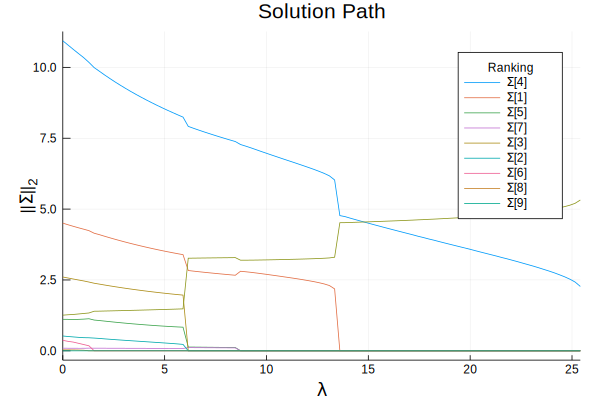

In [28]:
plotsolpath(Σ̂path, λpath; legendout=false)

The above ranking could have been obtained by using function `rankvarcomps` as well:

In [29]:
ranking, zerovarcomps = rankvarcomps(Σ̂path)

([4, 1, 5, 7, 3, 2, 6, 8, 9], [10])

Note that output includes two vectors. The first vector `nonzerovarcomps` displays indices of variance components in the order they entered the solution path; the second vector `zerovarcomps` shows indices of those that are zero (except when $\lambda=0)$ and residual variance component, in no particular order. 